<a href="https://colab.research.google.com/github/farhanwew/Transcranial-Doppler-Biomed/blob/main/TCD_Waveform_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from google.colab import userdata
username = userdata.get('KAGGLE_USERNAME')
key = userdata.get('KAGGLE_KEY')
%env KAGGLE_USERNAME=$username
%env KAGGLE_KEY=$key

In [2]:
#!/bin/bash
!kaggle datasets download farhanwew/tcd-ultrasound-data

Dataset URL: https://www.kaggle.com/datasets/farhanwew/tcd-ultrasound-data
License(s): unknown
 99% 1.80G/1.82G [00:21<00:00, 47.9MB/s]
100% 1.82G/1.82G [00:22<00:00, 88.9MB/s]


In [3]:
%%capture
!unzip /content/tcd-ultrasound-data.zip

/tmp/ipython-input-54534205.py:58: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(IQ, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, window="hann", boundary=None)


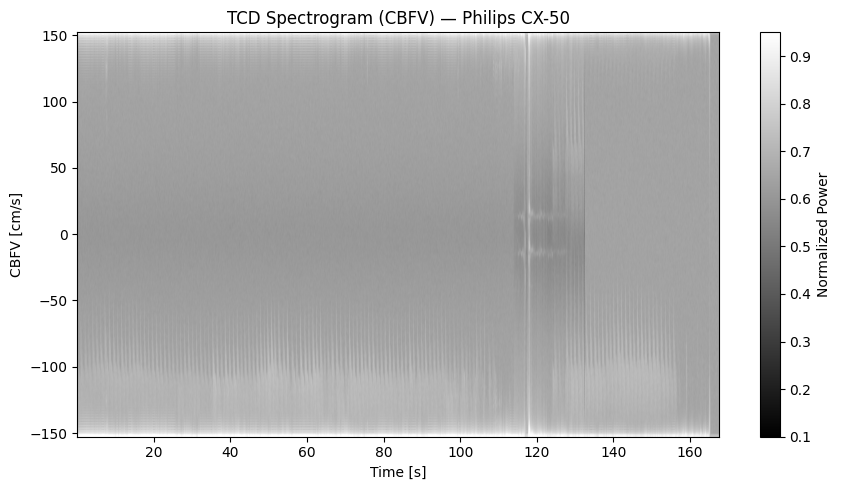

/tmp/ipython-input-54534205.py:58: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(IQ, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, window="hann", boundary=None)


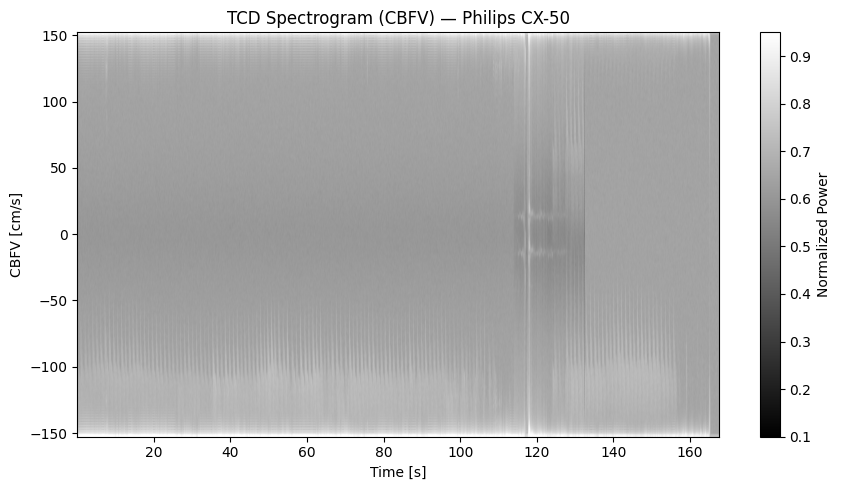

In [5]:
# tcd_spectrogram.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft, medfilt2d
from typing import Tuple

def correct_timestamp_overflow(t_sec: np.ndarray) -> np.ndarray:
    """
    Perbaiki loncatan negatif pada vektor waktu (overflow counter).
    Mirip logika MATLAB: deteksi diff < -median(diff) lalu geser segmen berikutnya.
    """
    t = t_sec.copy()
    diffT = np.diff(t)
    Ts_med = np.median(diffT[diffT > 0]) if np.any(diffT > 0) else np.median(diffT)

    # indeks di mana terjadi loncatan negatif signifikan
    overflow_idx = np.where(diffT < -Ts_med)[0]
    if overflow_idx.size == 0:
        return t

    # tambahkan sentinel akhir agar loop mudah
    overflow_idx = np.concatenate([overflow_idx, [len(t) - 1]])

    for i in range(len(overflow_idx) - 1):
        i0 = overflow_idx[i]
        # DeltaT = |t[i] - t[i+1]| + Ts_med (mengacu skrip MATLAB)
        DeltaT = abs(t[i0] - t[i0 + 1]) + Ts_med
        start = i0 + 1
        end = overflow_idx[i + 1] + 1
        t[start:end] = t[start:end] + DeltaT

    return t

def resample_iq(t_old: np.ndarray, I: np.ndarray, Q: np.ndarray, Ts_target: float
               ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Resample I/Q ke grid waktu seragam dengan interval Ts_target.
    Interpolasi pchip ~ cubic di MATLAB → gunakan cubic spline-ish 'pchip' tidak ada langsung,
    maka dipakai 'cubic' dari pandas/NumPy bila data cukup rapat; fallback ke 'linear'.
    """
    fs_target = 1.0 / Ts_target
    t_new = np.arange(t_old[0], t_old[-1] + 1e-12, Ts_target)

    # gunakan numpy.interp (linear) agar andal; cukup untuk STFT
    I_new = np.interp(t_new, t_old, I)
    Q_new = np.interp(t_new, t_old, Q)
    return t_new, I_new, Q_new, fs_target

def generate_spectrogram(IQ: np.ndarray, fs: float,
                         nperseg: int = 256, noverlap: int = 192, nfft: int = 512
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Hitung spectrogram power dari sinyal kompleks IQ.
    Kembalikan: frekuensi(Hz), waktu(s), Spektrum Power (magnitude^2).
    """
    # STFT pada sinyal kompleks
    f, t, Zxx = stft(IQ, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, window="hann", boundary=None)
    SP = (np.abs(Zxx) ** 2).astype(np.float64)  # power spectrum
    return f, t, SP

def freq_to_velocity(f_hz: np.ndarray, fc: float, c: float, angle_deg: float) -> np.ndarray:
    """
    Konversi frekuensi Doppler → kecepatan aliran (cm/s)
    v = (f * c) / (2 * fc * cos(theta))  ; lalu ×100 untuk cm/s
    """
    angle_rad = np.deg2rad(angle_deg)
    denom = 2.0 * fc * np.cos(angle_rad)
   # hindari pembagian 0 jika angle=90°
    denom = np.where(np.isclose(denom, 0.0), np.finfo(float).eps, denom)
    v_ms = (f_hz * c) / denom
    return 100.0 * v_ms  # cm/s

def normalize_and_filter(SP: np.ndarray, median_kernel=(3, 3)) -> np.ndarray:
    """
    Log-kompresi, normalisasi 0..1, median filter 2D.
    """
    eps = np.finfo(float).eps
    SP_log = np.log2(SP + eps)
    SP_log -= SP_log.min()
    m = SP_log.max()
    if m > 0:
        SP_norm = SP_log / m
    else:
        SP_norm = SP_log
    SP_med = medfilt2d(SP_norm, kernel_size=median_kernel)
    return SP_med

def plot_spectrogram(t_spec: np.ndarray, v_spec: np.ndarray, SP_proc: np.ndarray,
                     clim=(0.1, 0.95), cmap="gray", title="TCD Spectrogram (CBFV)") -> None:
    plt.figure(figsize=(9, 5))
    # extent: [xmin, xmax, ymin, ymax]; origin='lower' ≈ axis xy di MATLAB
    extent = [t_spec.min(), t_spec.max(), v_spec.min(), v_spec.max()]
    img = plt.imshow(SP_proc, aspect="auto", extent=extent, origin="lower", cmap=cmap)
    if clim is not None:
        img.set_clim(*clim)
    plt.xlabel("Time [s]")
    plt.ylabel("CBFV [cm/s]")
    plt.title(title)
    plt.colorbar(label="Normalized Power")
    plt.tight_layout()
    plt.show()

def main(
    filepath: str = "../Healthy Subjects/Healthy_Subjects_Recording_1.txt",
    sep: str = ",",
    fc: float = 1.75e6,   # Hz, carrier (Philips CX-50 example)
    c_sound: float = 1540.0,  # m/s
    angle_deg: float = 0.0,
    Ts_target: float = 1.44e-4,  # s → fs ≈ 6944 Hz
    nperseg: int = 256,
    noverlap: int = 192,
    nfft: int = 512,
    clim: Tuple[float, float] = (0.1, 0.95),
):
    # 1) Load data
    # Jika file pakai delimiter tab/spasi, set sep=r"\s+" dan engine="python"
    df = pd.read_csv(filepath, sep=sep, engine="python")
    # Asumsi kolom bernama 't', 'I', 'Q'
    t = df["t"].to_numpy(dtype=np.float64)
    I = df["I"].to_numpy(dtype=np.float64)
    Q = df["Q"].to_numpy(dtype=np.float64)

    # 2) Zeroing timestamp & ubah mikrodetik → detik (seperti MATLAB)
    t = (t - t[0]) / 1e6

    # 3) Koreksi overflow timestamp
    t = correct_timestamp_overflow(t)

    # 4) Resample ke grid seragam
    t_uniform, Iu, Qu, fs = resample_iq(t, I, Q, Ts_target)
    IQ = Iu + 1j * Qu

    # 5) Spectrogram (STFT)
    f_sp, t_sp, SP = generate_spectrogram(IQ, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

    # 6) Frekuensi → kecepatan (cm/s)
    v_sp = freq_to_velocity(f_sp, fc=fc, c=c_sound, angle_deg=angle_deg)

    # 7) Log-normalisasi + median filter
    SP_proc = normalize_and_filter(SP, median_kernel=(3, 3))

    # 8) Visualisasi
    plot_spectrogram(t_sp, v_sp, SP_proc, clim=clim, cmap="gray",
                     title="TCD Spectrogram (CBFV) — Philips CX-50")

if __name__ == "__main__":
    # Contoh pemanggilan default:
    main(filepath="Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_1.txt", sep=",")
    main(filepath="Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_1.txt", sep=",")

# ICU Patient

File loaded successfully!
Data shape: (4222524, 3)
Data loaded: 4222524 samples

Total duration: 621.19 seconds (10.35 minutes)
Sampling frequency: 6944.44 Hz

Generating full spectrogram...


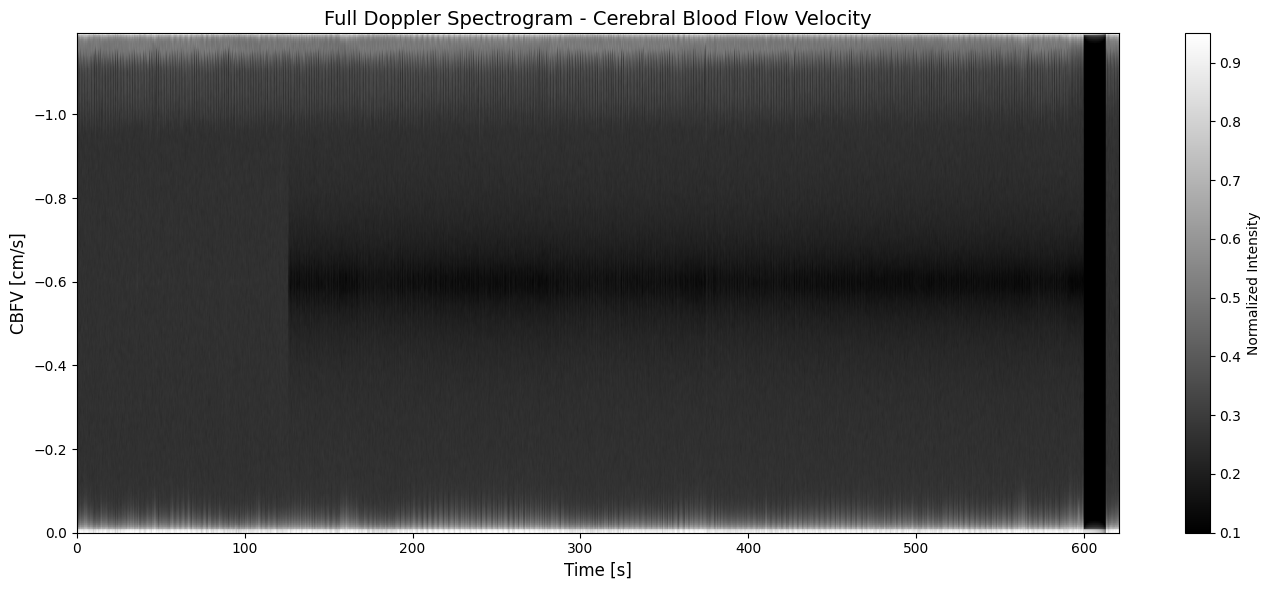


Generating per-minute spectrograms...
Number of minutes: 11


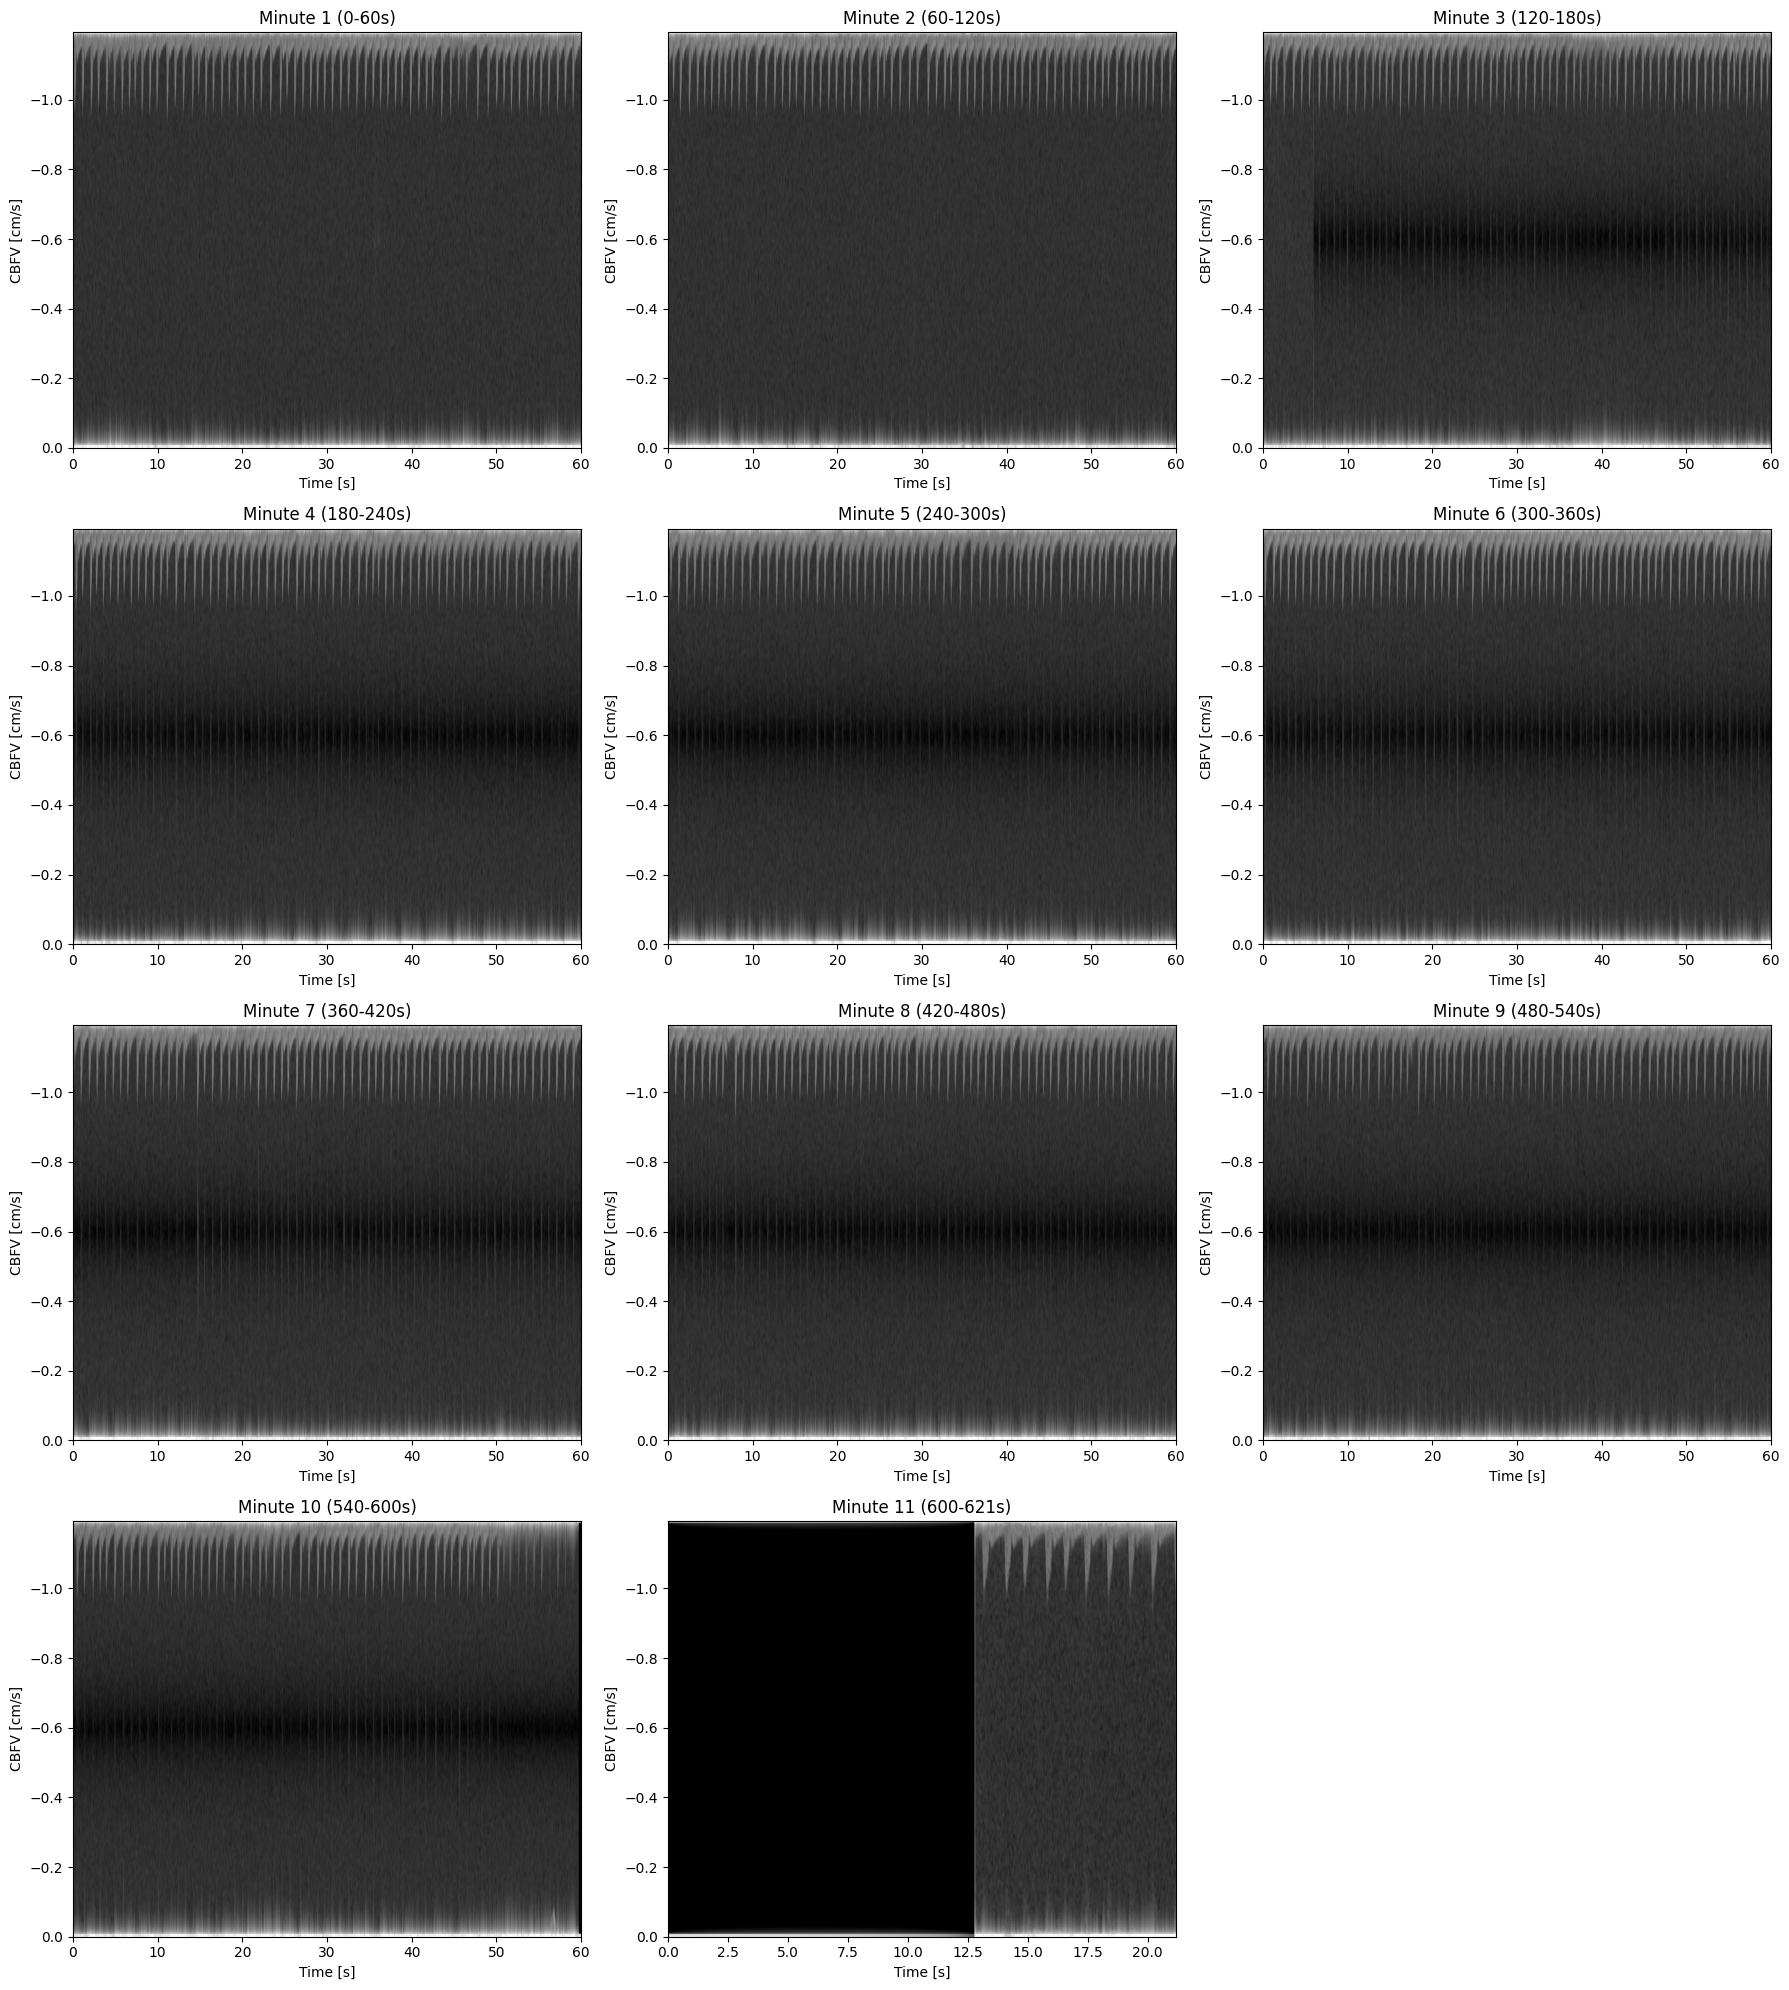


Generating box plots...


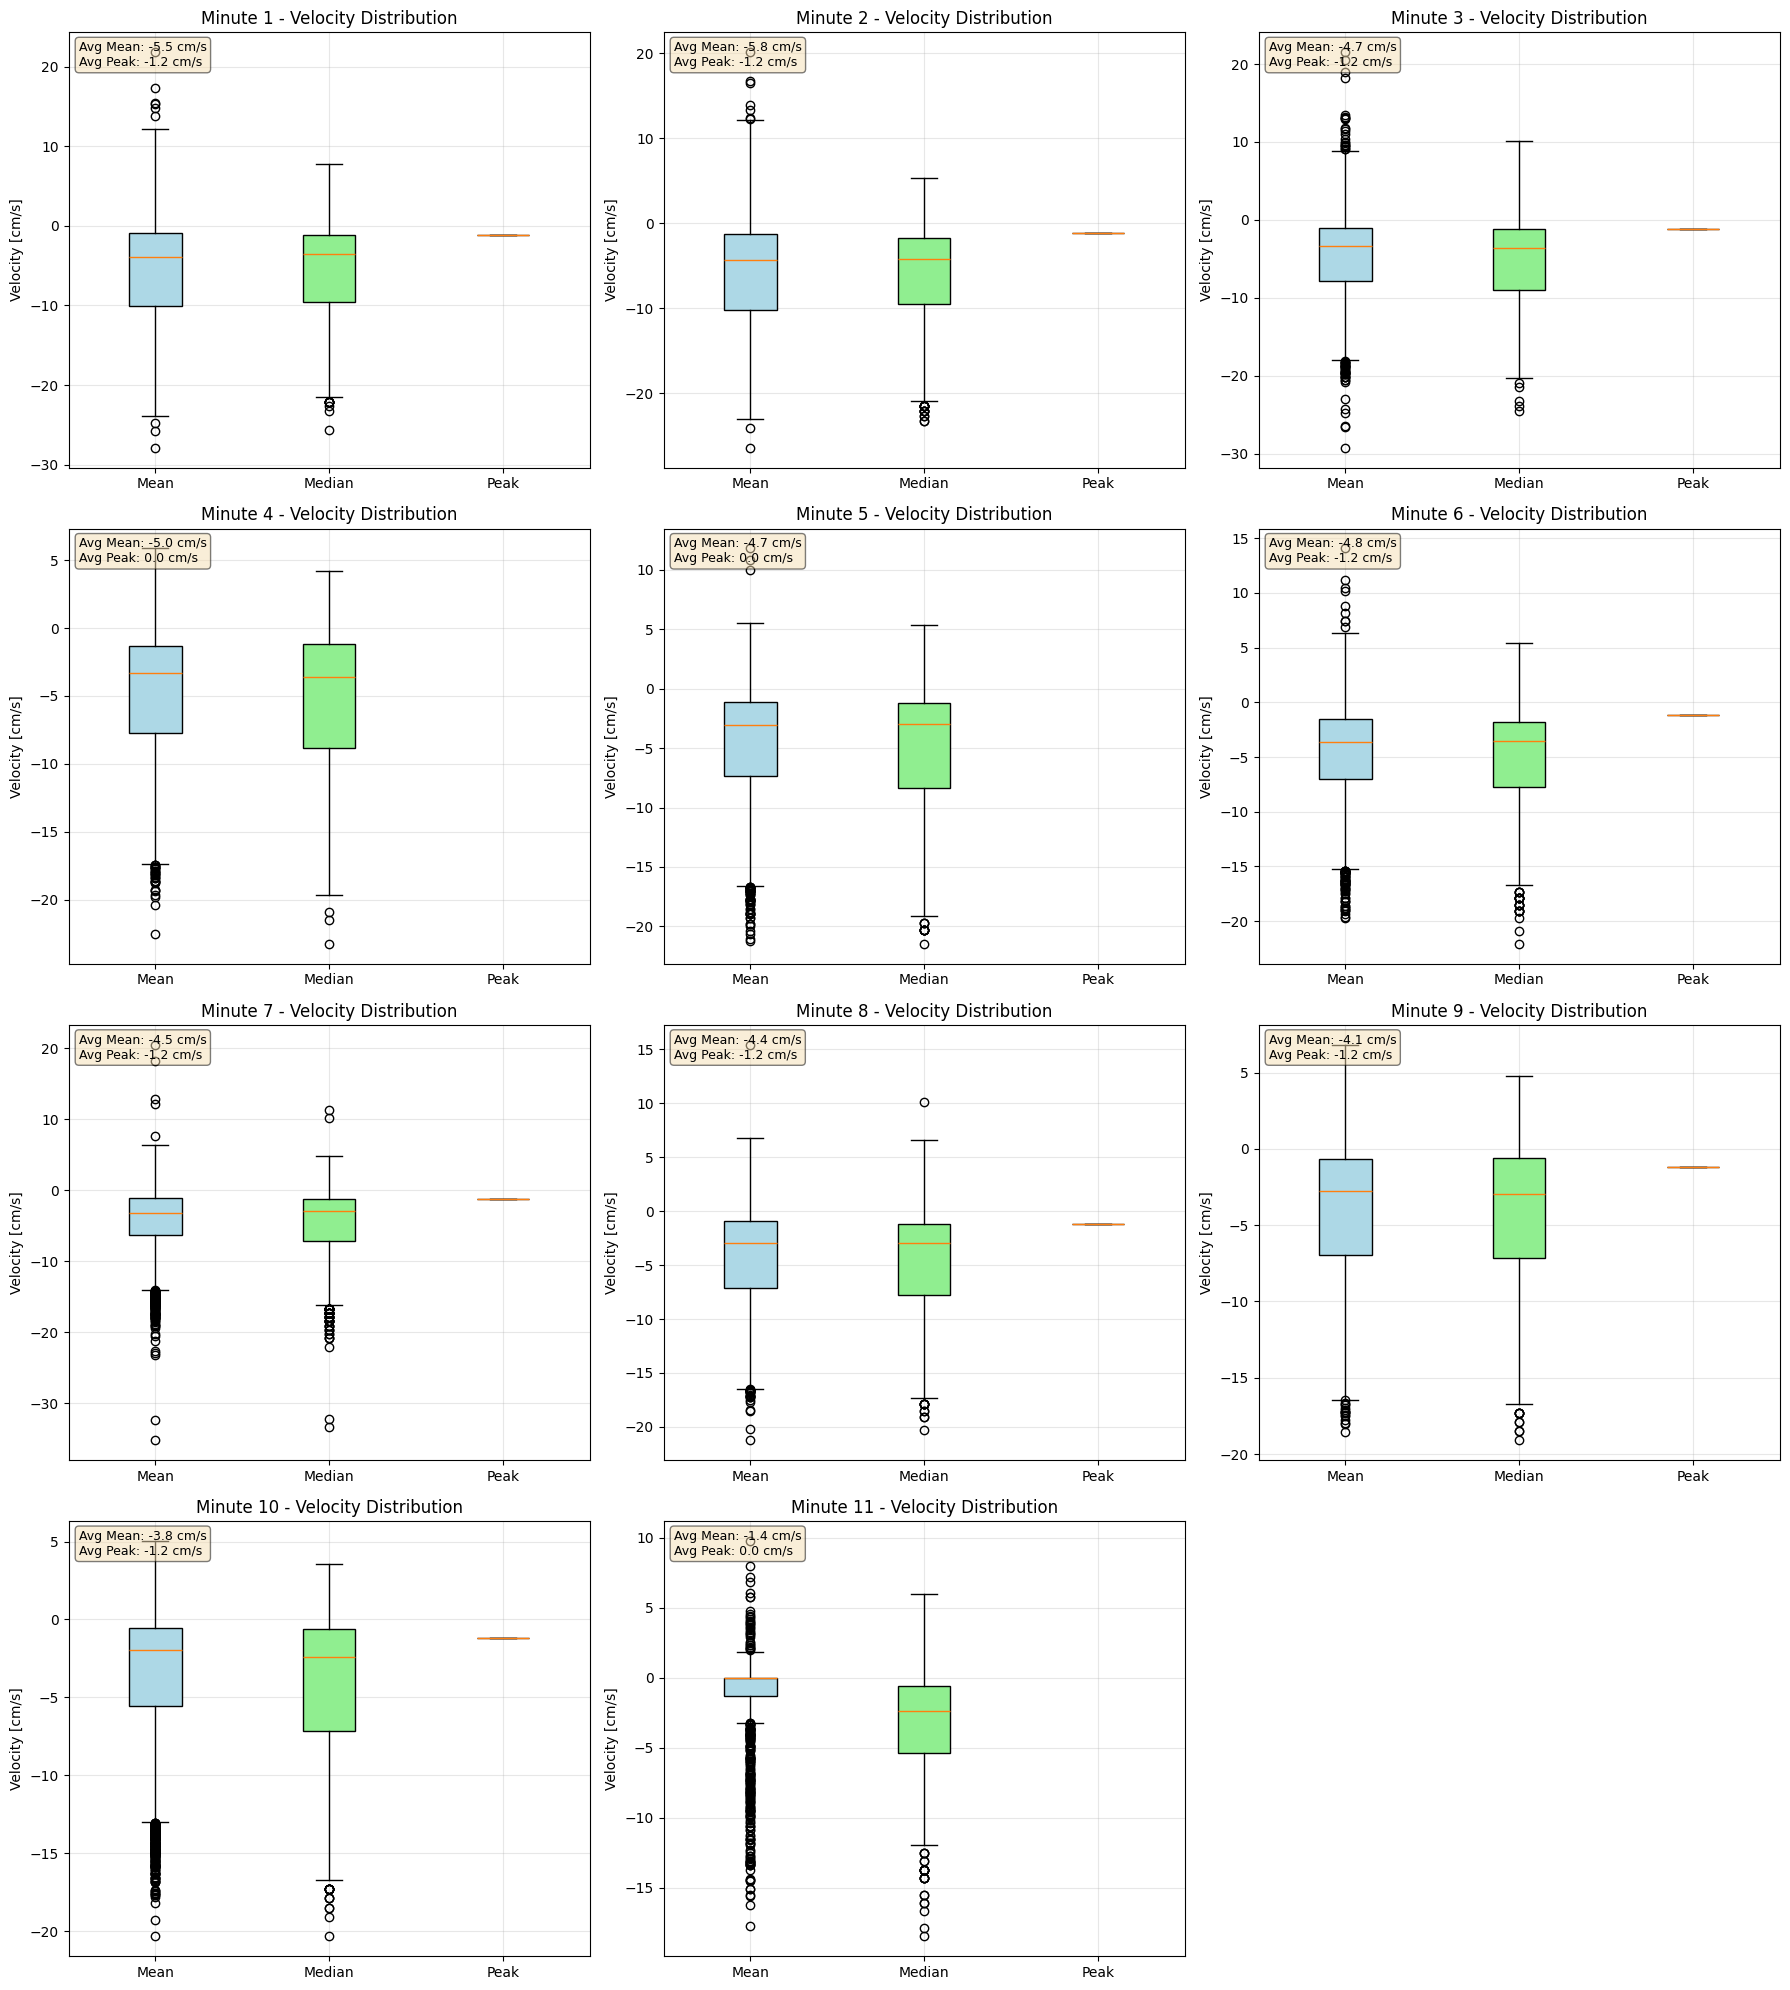


✓ Analysis complete!
Total minutes analyzed: 11
Grid layout: 4 rows × 3 columns


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import median_filter

def generate_spectrogram(iq_signal, fs, t_echo, nperseg=256, noverlap=None):
    """Generate spectrogram from IQ signal"""
    if noverlap is None:
        noverlap = nperseg // 2

    # Compute STFT for complex signal (two-sided spectrum)
    freqs, t_spec, Zxx = signal.stft(iq_signal, fs=fs,
                                      nperseg=nperseg,
                                      noverlap=noverlap,
                                      window='hann',
                                      return_onesided=False)

    # Compute magnitude
    spec = np.abs(Zxx)

    return freqs, t_spec, spec, fs


def extract_velocity_stats(SP, v_spectrogram, threshold=0.3):
    """Extract velocity statistics from spectrogram"""
    stats = []

    for col in range(SP.shape[1]):
        spectrum = SP[:, col]
        # Get indices where signal is above threshold
        valid_idx = spectrum > threshold

        if np.any(valid_idx):
            velocities = v_spectrogram[valid_idx]
            intensities = spectrum[valid_idx]

            # Weighted statistics
            mean_vel = np.average(velocities, weights=intensities)
            max_vel = velocities[np.argmax(intensities)]

            # Percentiles
            sorted_vels = np.sort(velocities)
            p25 = np.percentile(sorted_vels, 25)
            p50 = np.percentile(sorted_vels, 50)
            p75 = np.percentile(sorted_vels, 75)

            stats.append({
                'mean': mean_vel,
                'max': max_vel,
                'min': np.min(velocities),
                'p25': p25,
                'p50': p50,
                'p75': p75
            })
        else:
            stats.append({
                'mean': 0, 'max': 0, 'min': 0,
                'p25': 0, 'p50': 0, 'p75': 0
            })

    return stats


# ============================================================================
# PARAMETERS
# ============================================================================
fc = 1.75e6  # Transmit center frequency [Hz]
ss = 1540    # Speed of sound [m/s]
angle = 0    # Doppler angle [deg]
size_sp_filt = (3, 3)  # Median filter kernel size

# ============================================================================
# LOAD DATA
# ============================================================================
filepath = ''
filename = '/content/ICU Patients/ICU Patients/ICU_Patients_Recording_10_ICA.txt'

data = pd.read_csv(filepath + filename)
print("File loaded successfully!")
print(f"Data shape: {data.shape}")

t_echo = data['t'].values
I = data['I'].values
Q = data['Q'].values

print(f"Data loaded: {len(t_echo)} samples")

# ============================================================================
# PREPROCESSING
# ============================================================================
# Zero timestamp and convert to seconds
t_echo = (t_echo - t_echo[0]) / 1e6
diff_t = np.diff(t_echo)
Ts_echo = np.median(diff_t)

# Correct for overflow
overflow_index = np.where(diff_t < -Ts_echo)[0]
overflow_index = np.append(overflow_index, len(t_echo) - 1)

for i in range(len(overflow_index) - 1):
    delta_t = abs(t_echo[overflow_index[i]] - t_echo[overflow_index[i] + 1]) + Ts_echo
    win = slice(overflow_index[i] + 1, overflow_index[i + 1] + 1)
    t_echo[win] = t_echo[win] + delta_t

# Resample IQ signal
Ts_echo = 1.4400e-04
fs_echo = 1 / Ts_echo
t_uniform = np.arange(t_echo[0], t_echo[-1], Ts_echo)

I_interp = PchipInterpolator(t_echo, I)
Q_interp = PchipInterpolator(t_echo, Q)

I = I_interp(t_uniform)
Q = Q_interp(t_uniform)
IQ = I + 1j * Q
t_echo = t_uniform

duration_total = t_echo[-1]
print(f"\nTotal duration: {duration_total:.2f} seconds ({duration_total/60:.2f} minutes)")
print(f"Sampling frequency: {fs_echo:.2f} Hz")

# ============================================================================
# FULL SPECTROGRAM
# ============================================================================
print("\nGenerating full spectrogram...")
freqs_sp, t_spectrogram, SP_full, fs_sp = generate_spectrogram(IQ, fs_echo, t_echo)

# Convert frequency to velocity
v_spectrogram = 100 * freqs_sp * ss / (2 * fc * np.cos(np.radians(angle)))

# Process spectrum
SP_full = np.log2(SP_full + 1e-10)
SP_full = SP_full / np.max(SP_full)
SP_full = median_filter(SP_full, size=size_sp_filt)

# Plot full spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(SP_full, aspect='auto', origin='lower',
           extent=[t_spectrogram[0], t_spectrogram[-1],
                   v_spectrogram[0], v_spectrogram[-1]],
           cmap='gray', vmin=0.1, vmax=0.95)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('CBFV [cm/s]', fontsize=12)
plt.title('Full Doppler Spectrogram - Cerebral Blood Flow Velocity', fontsize=14)
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()

# ============================================================================
# PER-MINUTE SPECTROGRAMS
# ============================================================================
print("\nGenerating per-minute spectrograms...")

# Calculate number of minutes
n_minutes = int(np.ceil(duration_total / 60))
print(f"Number of minutes: {n_minutes}")

# Calculate grid layout
n_cols = 3
n_rows = int(np.ceil(n_minutes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

minute_stats = []

for minute in range(n_minutes):
    # Time window for this minute
    t_start = minute * 60
    t_end = min((minute + 1) * 60, duration_total)

    # Find indices for this minute
    idx_start = np.searchsorted(t_echo, t_start)
    idx_end = np.searchsorted(t_echo, t_end)

    if idx_end - idx_start < 100:  # Skip if too few samples
        continue

    # Extract data for this minute
    IQ_minute = IQ[idx_start:idx_end]
    t_minute = t_echo[idx_start:idx_end] - t_start

    # Generate spectrogram
    freqs_min, t_spec_min, SP_min, _ = generate_spectrogram(IQ_minute, fs_echo, t_minute)

    # Convert to velocity
    v_min = 100 * freqs_min * ss / (2 * fc * np.cos(np.radians(angle)))

    # Process
    SP_min = np.log2(SP_min + 1e-10)
    SP_min = SP_min / np.max(SP_min)
    SP_min = median_filter(SP_min, size=size_sp_filt)

    # Extract statistics
    stats = extract_velocity_stats(SP_min, v_min)
    minute_stats.append({
        'minute': minute + 1,
        'mean_velocities': [s['mean'] for s in stats],
        'max_velocities': [s['max'] for s in stats],
        'p50_velocities': [s['p50'] for s in stats]
    })

    # Plot
    row = minute // n_cols
    col = minute % n_cols
    ax = axes[row, col]

    im = ax.imshow(SP_min, aspect='auto', origin='lower',
                   extent=[t_spec_min[0], t_spec_min[-1], v_min[0], v_min[-1]],
                   cmap='gray', vmin=0.1, vmax=0.95)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('CBFV [cm/s]')
    ax.set_title(f'Minute {minute+1} ({t_start:.0f}-{t_end:.0f}s)')

# Remove empty subplots
for minute in range(n_minutes, n_rows * n_cols):
    row = minute // n_cols
    col = minute % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# ============================================================================
# BOX PLOTS - 3 x N GRID
# ============================================================================
print("\nGenerating box plots...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, stats in enumerate(minute_stats):
    if i >= n_minutes:
        break

    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Prepare data for box plot
    mean_vels = np.array(stats['mean_velocities'])
    max_vels = np.array(stats['max_velocities'])
    p50_vels = np.array(stats['p50_velocities'])

    # Remove zeros for better visualization
    mean_vels = mean_vels[mean_vels != 0]
    max_vels = max_vels[max_vels != 0]
    p50_vels = p50_vels[p50_vels != 0]

    # Box plot
    bp = ax.boxplot([mean_vels, p50_vels, max_vels],
                     tick_labels=['Mean', 'Median', 'Peak'],
                     patch_artist=True)

    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel('Velocity [cm/s]')
    ax.set_title(f'Minute {stats["minute"]} - Velocity Distribution')
    ax.grid(True, alpha=0.3)

    # Add statistics text
    mean_avg = np.mean(mean_vels) if len(mean_vels) > 0 else 0
    max_avg = np.mean(max_vels) if len(max_vels) > 0 else 0
    ax.text(0.02, 0.98, f'Avg Mean: {mean_avg:.1f} cm/s\nAvg Peak: {max_avg:.1f} cm/s',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

# Remove empty subplots
for i in range(len(minute_stats), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print(f"Total minutes analyzed: {len(minute_stats)}")
print(f"Grid layout: {n_rows} rows × {n_cols} columns")

# Healthy Patient

File loaded successfully!
Data shape: (3803966, 3)
Data loaded: 3803966 samples

Total duration: 552.02 seconds (9.20 minutes)
Sampling frequency: 6944.44 Hz

Generating full spectrogram...


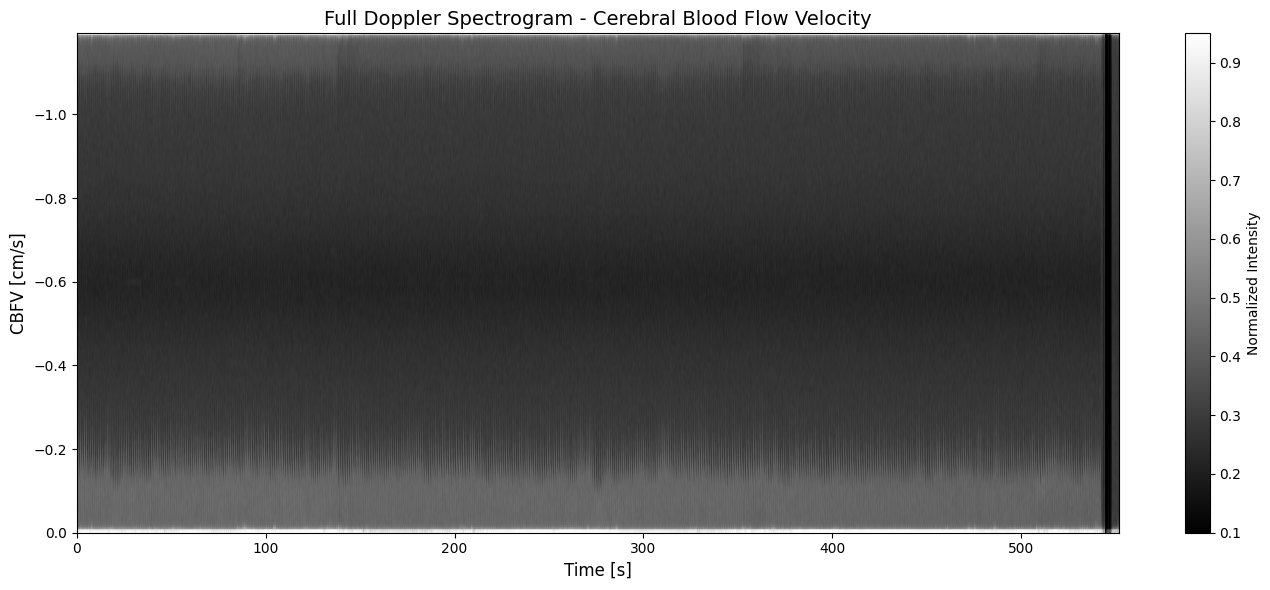


Generating per-minute spectrograms...
Number of minutes: 10


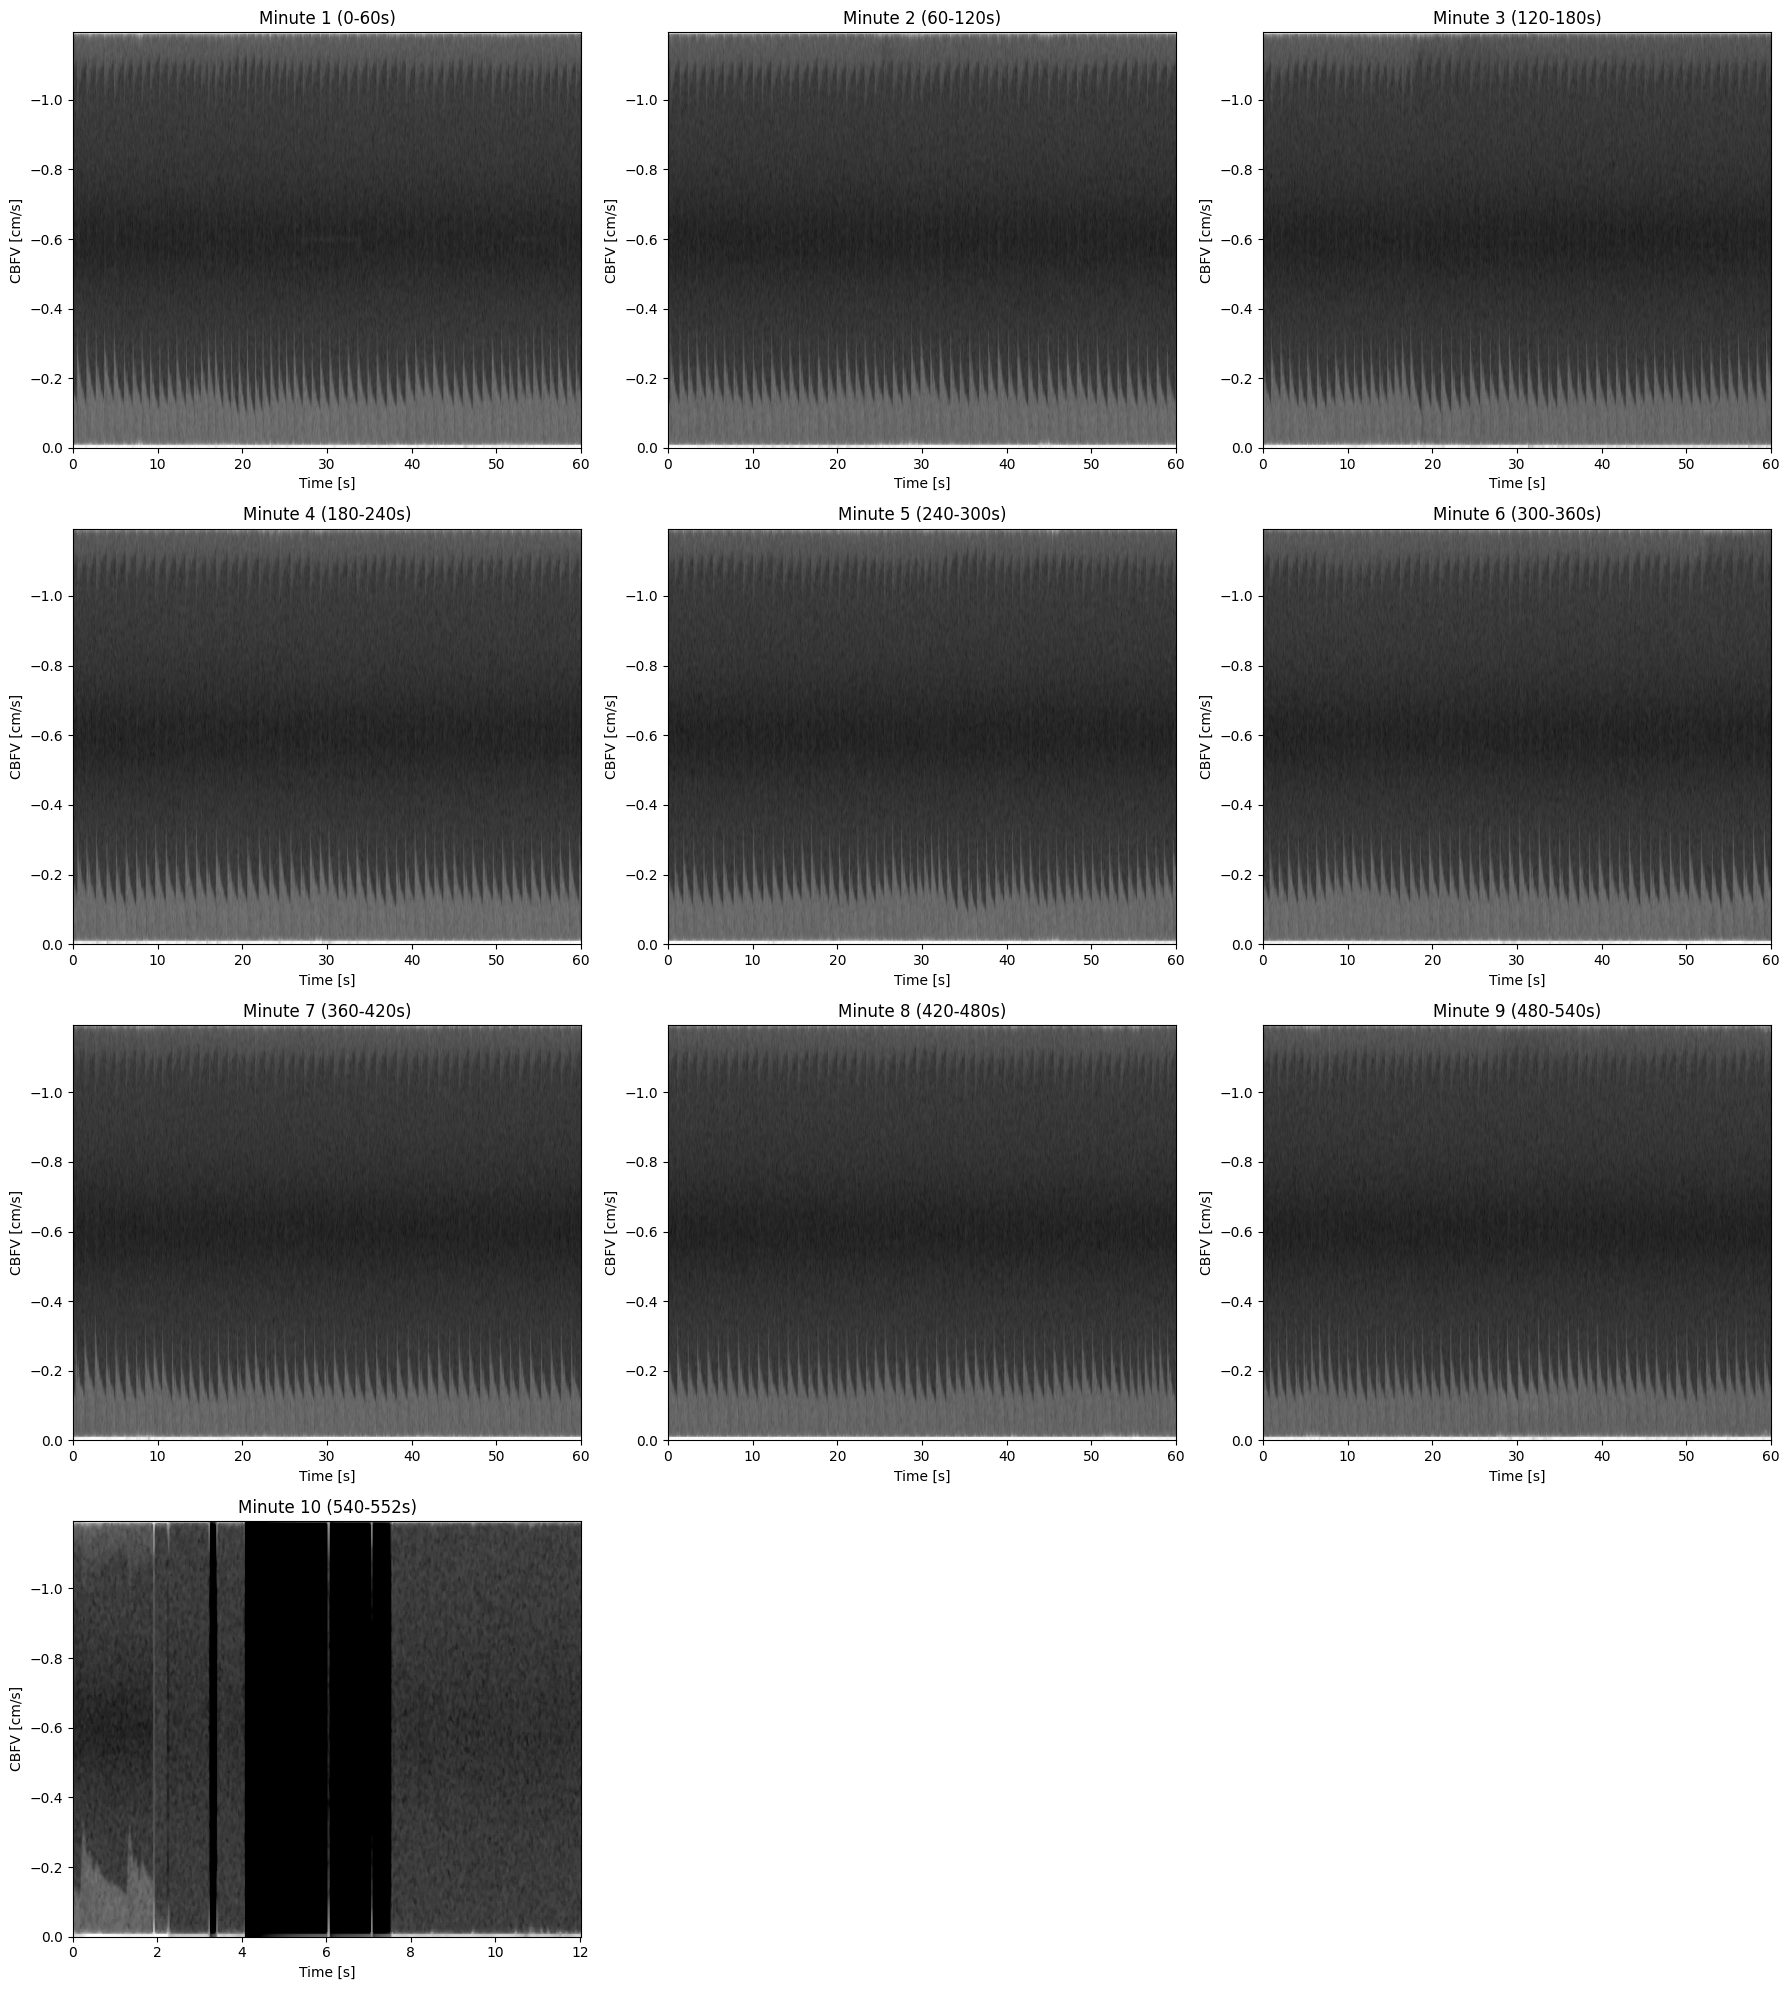


Generating box plots...


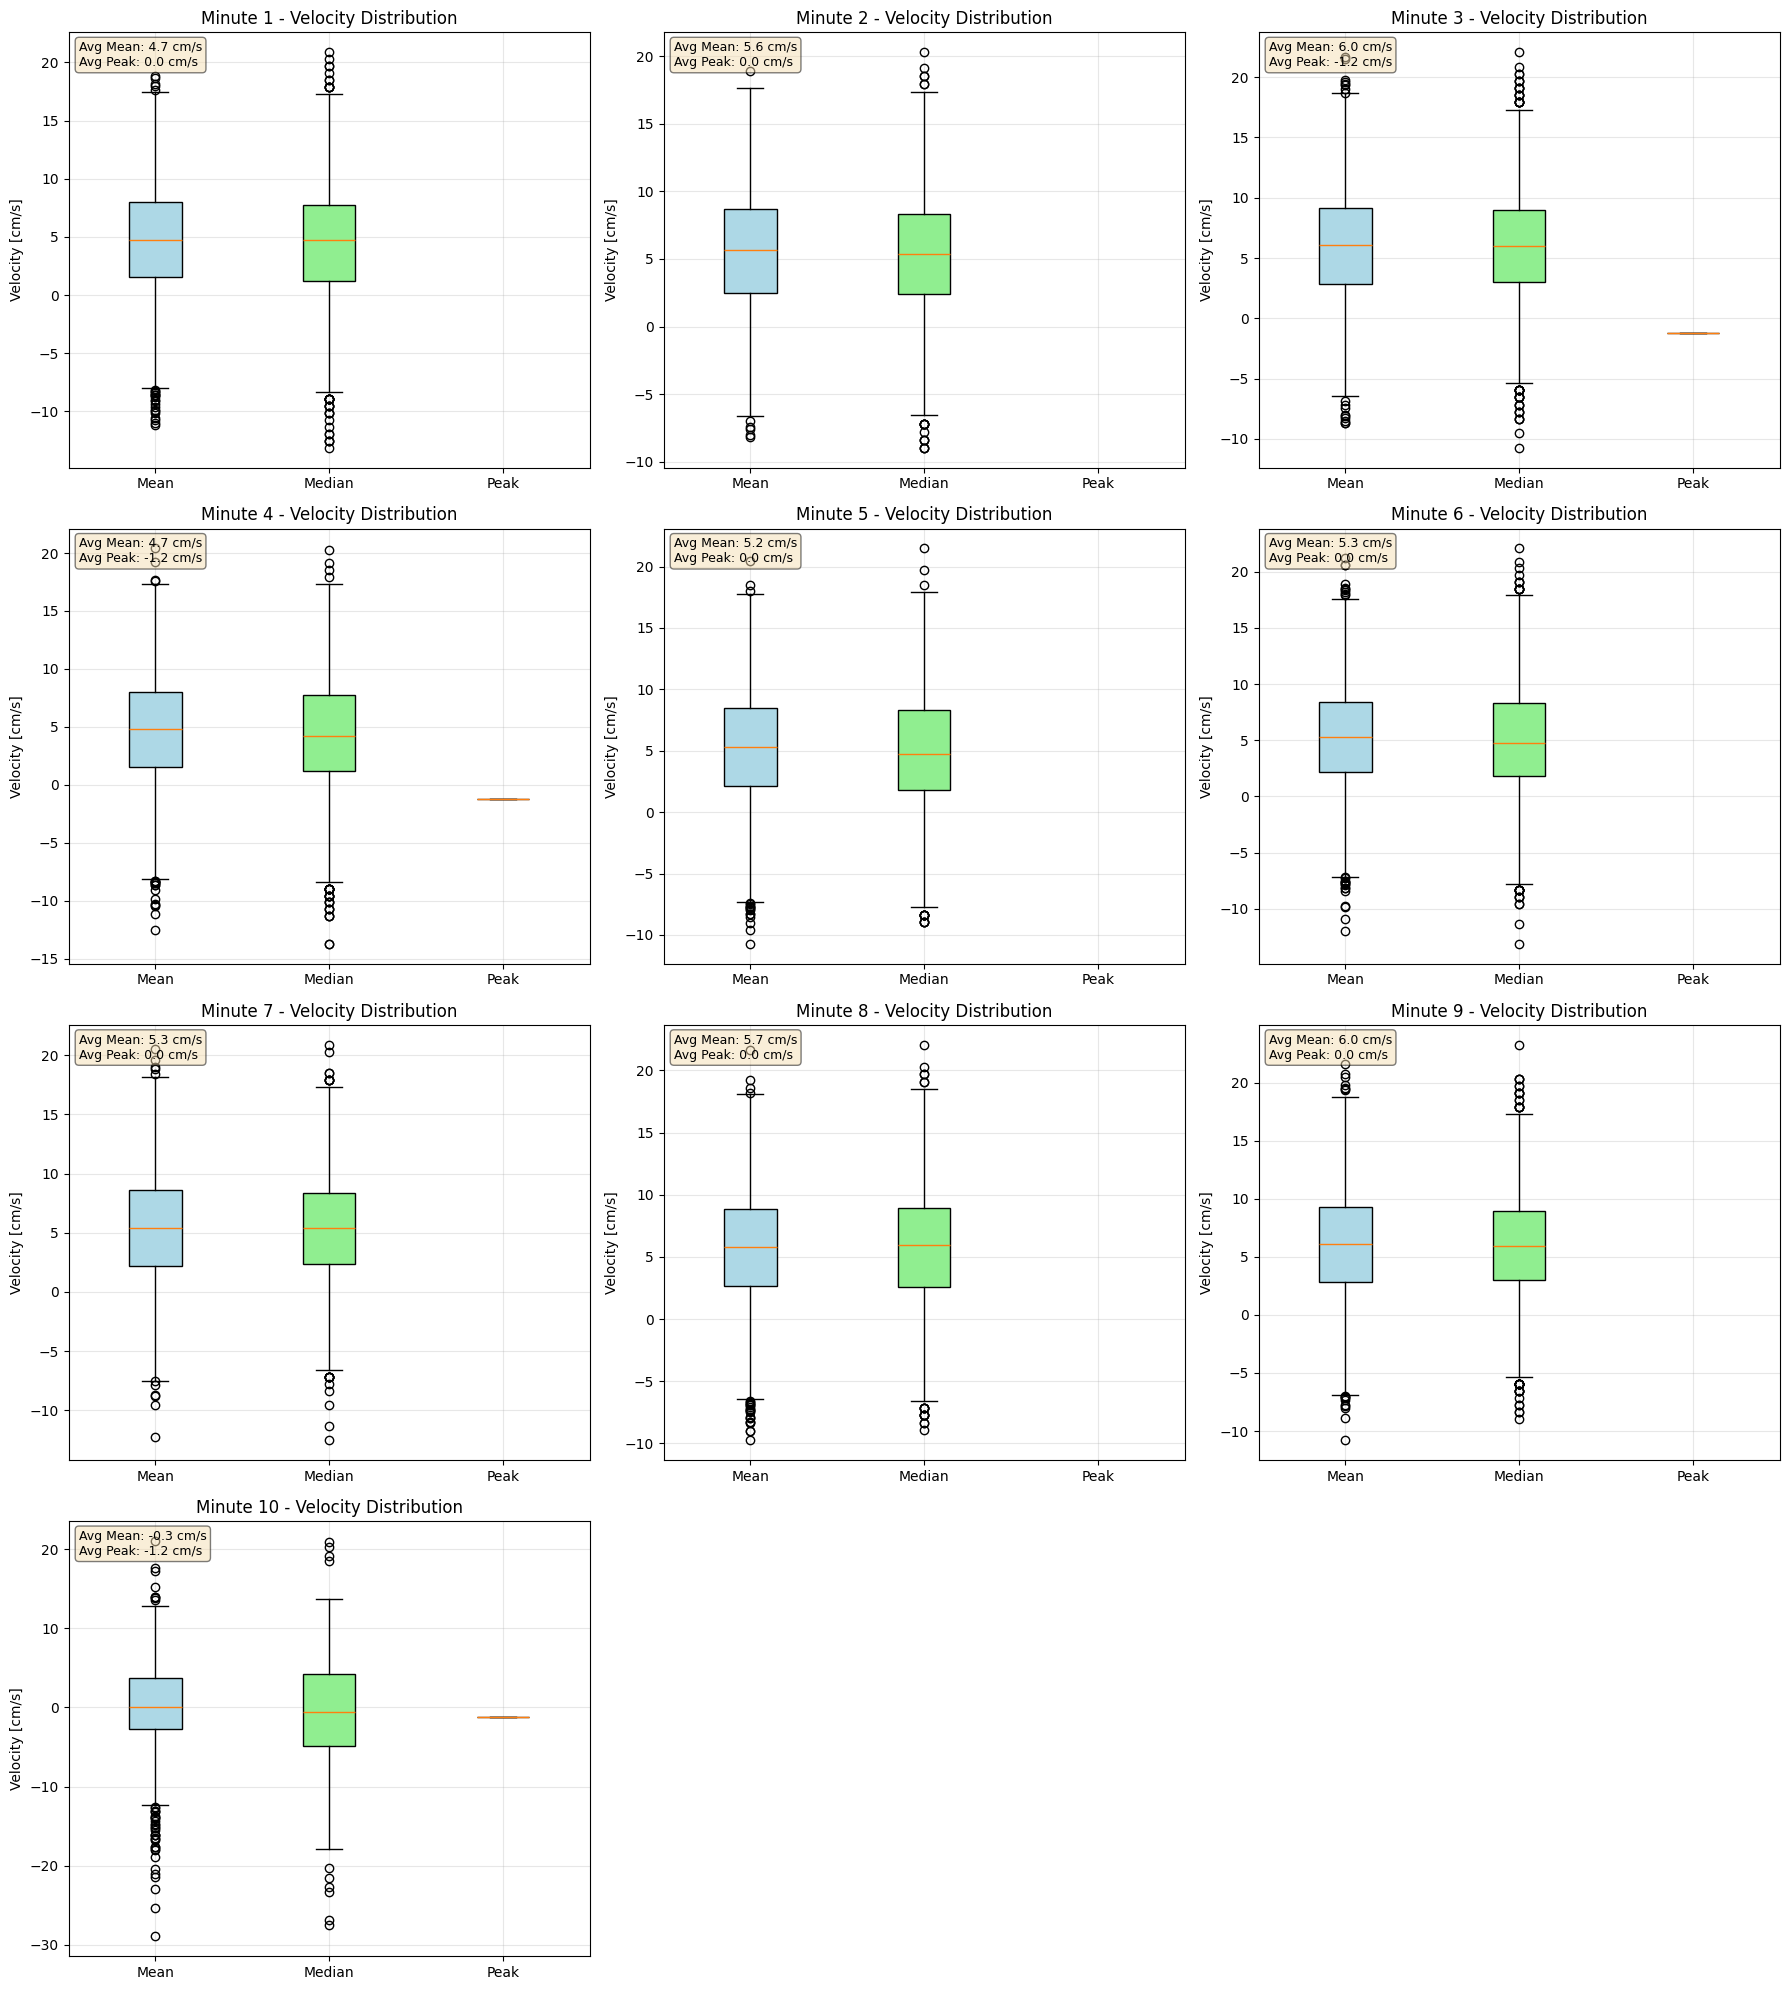


✓ Analysis complete!
Total minutes analyzed: 10
Grid layout: 4 rows × 3 columns


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import median_filter

def generate_spectrogram(iq_signal, fs, t_echo, nperseg=256, noverlap=None):
    """Generate spectrogram from IQ signal"""
    if noverlap is None:
        noverlap = nperseg // 2

    # Compute STFT for complex signal (two-sided spectrum)
    freqs, t_spec, Zxx = signal.stft(iq_signal, fs=fs,
                                      nperseg=nperseg,
                                      noverlap=noverlap,
                                      window='hann',
                                      return_onesided=False)

    # Compute magnitude
    spec = np.abs(Zxx)

    return freqs, t_spec, spec, fs


def extract_velocity_stats(SP, v_spectrogram, threshold=0.3):
    """Extract velocity statistics from spectrogram"""
    stats = []

    for col in range(SP.shape[1]):
        spectrum = SP[:, col]
        # Get indices where signal is above threshold
        valid_idx = spectrum > threshold

        if np.any(valid_idx):
            velocities = v_spectrogram[valid_idx]
            intensities = spectrum[valid_idx]

            # Weighted statistics
            mean_vel = np.average(velocities, weights=intensities)
            max_vel = velocities[np.argmax(intensities)]

            # Percentiles
            sorted_vels = np.sort(velocities)
            p25 = np.percentile(sorted_vels, 25)
            p50 = np.percentile(sorted_vels, 50)
            p75 = np.percentile(sorted_vels, 75)

            stats.append({
                'mean': mean_vel,
                'max': max_vel,
                'min': np.min(velocities),
                'p25': p25,
                'p50': p50,
                'p75': p75
            })
        else:
            stats.append({
                'mean': 0, 'max': 0, 'min': 0,
                'p25': 0, 'p50': 0, 'p75': 0
            })

    return stats


# ============================================================================
# PARAMETERS
# ============================================================================
fc = 1.75e6  # Transmit center frequency [Hz]
ss = 1540    # Speed of sound [m/s]
angle = 0    # Doppler angle [deg]
size_sp_filt = (3, 3)  # Median filter kernel size

# ============================================================================
# LOAD DATA
# ============================================================================
filepath = ''
filename = '/content/Healthy Subjects/Healthy Subjects/Healthy_Subjects_Recording_8.txt'

data = pd.read_csv(filepath + filename)
print("File loaded successfully!")
print(f"Data shape: {data.shape}")

t_echo = data['t'].values
I = data['I'].values
Q = data['Q'].values

print(f"Data loaded: {len(t_echo)} samples")

# ============================================================================
# PREPROCESSING
# ============================================================================
# Zero timestamp and convert to seconds
t_echo = (t_echo - t_echo[0]) / 1e6
diff_t = np.diff(t_echo)
Ts_echo = np.median(diff_t)

# Correct for overflow
overflow_index = np.where(diff_t < -Ts_echo)[0]
overflow_index = np.append(overflow_index, len(t_echo) - 1)

for i in range(len(overflow_index) - 1):
    delta_t = abs(t_echo[overflow_index[i]] - t_echo[overflow_index[i] + 1]) + Ts_echo
    win = slice(overflow_index[i] + 1, overflow_index[i + 1] + 1)
    t_echo[win] = t_echo[win] + delta_t

# Resample IQ signal
Ts_echo = 1.4400e-04
fs_echo = 1 / Ts_echo
t_uniform = np.arange(t_echo[0], t_echo[-1], Ts_echo)

I_interp = PchipInterpolator(t_echo, I)
Q_interp = PchipInterpolator(t_echo, Q)

I = I_interp(t_uniform)
Q = Q_interp(t_uniform)
IQ = I + 1j * Q
t_echo = t_uniform

duration_total = t_echo[-1]
print(f"\nTotal duration: {duration_total:.2f} seconds ({duration_total/60:.2f} minutes)")
print(f"Sampling frequency: {fs_echo:.2f} Hz")

# ============================================================================
# FULL SPECTROGRAM
# ============================================================================
print("\nGenerating full spectrogram...")
freqs_sp, t_spectrogram, SP_full, fs_sp = generate_spectrogram(IQ, fs_echo, t_echo)

# Convert frequency to velocity
v_spectrogram = 100 * freqs_sp * ss / (2 * fc * np.cos(np.radians(angle)))

# Process spectrum
SP_full = np.log2(SP_full + 1e-10)
SP_full = SP_full / np.max(SP_full)
SP_full = median_filter(SP_full, size=size_sp_filt)

# Plot full spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(SP_full, aspect='auto', origin='lower',
           extent=[t_spectrogram[0], t_spectrogram[-1],
                   v_spectrogram[0], v_spectrogram[-1]],
           cmap='gray', vmin=0.1, vmax=0.95)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('CBFV [cm/s]', fontsize=12)
plt.title('Full Doppler Spectrogram - Cerebral Blood Flow Velocity', fontsize=14)
plt.colorbar(label='Normalized Intensity')
plt.tight_layout()
plt.show()

# ============================================================================
# PER-MINUTE SPECTROGRAMS
# ============================================================================
print("\nGenerating per-minute spectrograms...")

# Calculate number of minutes
n_minutes = int(np.ceil(duration_total / 60))
print(f"Number of minutes: {n_minutes}")

# Calculate grid layout
n_cols = 3
n_rows = int(np.ceil(n_minutes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

minute_stats = []

for minute in range(n_minutes):
    # Time window for this minute
    t_start = minute * 60
    t_end = min((minute + 1) * 60, duration_total)

    # Find indices for this minute
    idx_start = np.searchsorted(t_echo, t_start)
    idx_end = np.searchsorted(t_echo, t_end)

    if idx_end - idx_start < 100:  # Skip if too few samples
        continue

    # Extract data for this minute
    IQ_minute = IQ[idx_start:idx_end]
    t_minute = t_echo[idx_start:idx_end] - t_start

    # Generate spectrogram
    freqs_min, t_spec_min, SP_min, _ = generate_spectrogram(IQ_minute, fs_echo, t_minute)

    # Convert to velocity
    v_min = 100 * freqs_min * ss / (2 * fc * np.cos(np.radians(angle)))

    # Process
    SP_min = np.log2(SP_min + 1e-10)
    SP_min = SP_min / np.max(SP_min)
    SP_min = median_filter(SP_min, size=size_sp_filt)

    # Extract statistics
    stats = extract_velocity_stats(SP_min, v_min)
    minute_stats.append({
        'minute': minute + 1,
        'mean_velocities': [s['mean'] for s in stats],
        'max_velocities': [s['max'] for s in stats],
        'p50_velocities': [s['p50'] for s in stats]
    })

    # Plot
    row = minute // n_cols
    col = minute % n_cols
    ax = axes[row, col]

    im = ax.imshow(SP_min, aspect='auto', origin='lower',
                   extent=[t_spec_min[0], t_spec_min[-1], v_min[0], v_min[-1]],
                   cmap='gray', vmin=0.1, vmax=0.95)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('CBFV [cm/s]')
    ax.set_title(f'Minute {minute+1} ({t_start:.0f}-{t_end:.0f}s)')

# Remove empty subplots
for minute in range(n_minutes, n_rows * n_cols):
    row = minute // n_cols
    col = minute % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# ============================================================================
# BOX PLOTS - 3 x N GRID
# ============================================================================
print("\nGenerating box plots...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, stats in enumerate(minute_stats):
    if i >= n_minutes:
        break

    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Prepare data for box plot
    mean_vels = np.array(stats['mean_velocities'])
    max_vels = np.array(stats['max_velocities'])
    p50_vels = np.array(stats['p50_velocities'])

    # Remove zeros for better visualization
    mean_vels = mean_vels[mean_vels != 0]
    max_vels = max_vels[max_vels != 0]
    p50_vels = p50_vels[p50_vels != 0]

    # Box plot
    bp = ax.boxplot([mean_vels, p50_vels, max_vels],
                     tick_labels=['Mean', 'Median', 'Peak'],
                     patch_artist=True)

    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel('Velocity [cm/s]')
    ax.set_title(f'Minute {stats["minute"]} - Velocity Distribution')
    ax.grid(True, alpha=0.3)

    # Add statistics text
    mean_avg = np.mean(mean_vels) if len(mean_vels) > 0 else 0
    max_avg = np.mean(max_vels) if len(max_vels) > 0 else 0
    ax.text(0.02, 0.98, f'Avg Mean: {mean_avg:.1f} cm/s\nAvg Peak: {max_avg:.1f} cm/s',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

# Remove empty subplots
for i in range(len(minute_stats), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print(f"Total minutes analyzed: {len(minute_stats)}")
print(f"Grid layout: {n_rows} rows × {n_cols} columns")